In [2]:
%matplotlib inline

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from fbprophet import Prophet

In [3]:
df = pd.read_csv("data/avocado.csv.zip", parse_dates=["Date"])

del df['Unnamed: 0']
cols = ['Date', 'AveragePrice', 'type', 'region']
df = df[cols]
df = df[(df.region =='TotalUS') & (df.type == 'conventional') ] #& (df.Date >= '2016-01-01')

del df['region']
del df['type']

df = df.sort_values("Date")

df.columns = ['ds', 'y']
df.set_index('ds', inplace=True)

# Train test split 
train = df[:-12]
test = df[-12:]

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2015-01-04 to 2017-12-31
Data columns (total 1 columns):
y    157 non-null float64
dtypes: float64(1)
memory usage: 2.5 KB


# Only selecting `TotalUS` prices for `conventional` avocodos

In [4]:
train.head()

,y
ds,
2015-01-04,0.95
2015-01-11,1.01
2015-01-18,1.03
2015-01-25,1.04
2015-02-01,0.89


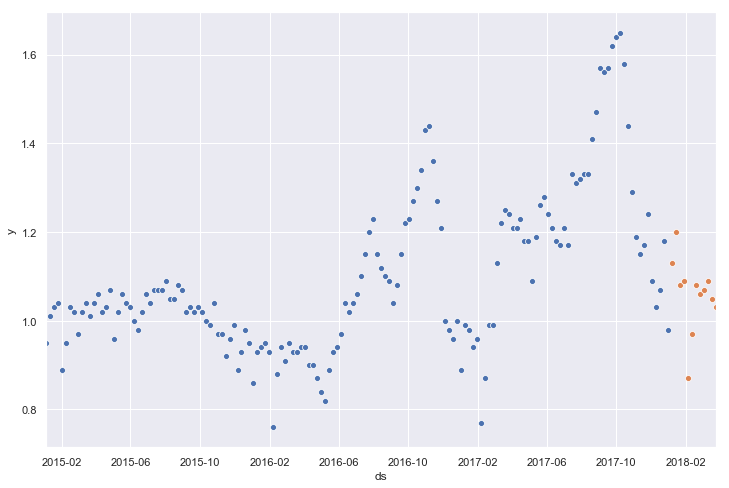

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

ax = sns.scatterplot(x=train.index, y=train.y)
ax = sns.scatterplot(x=test.index, y=test.y)

ax.axes.set_xlim(train.index.min(), test.index.max());

In [6]:
from pandas import DataFrame
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

# Stationarity check and Seasonal decomposition

Dickey–Fuller test: p=0.180980


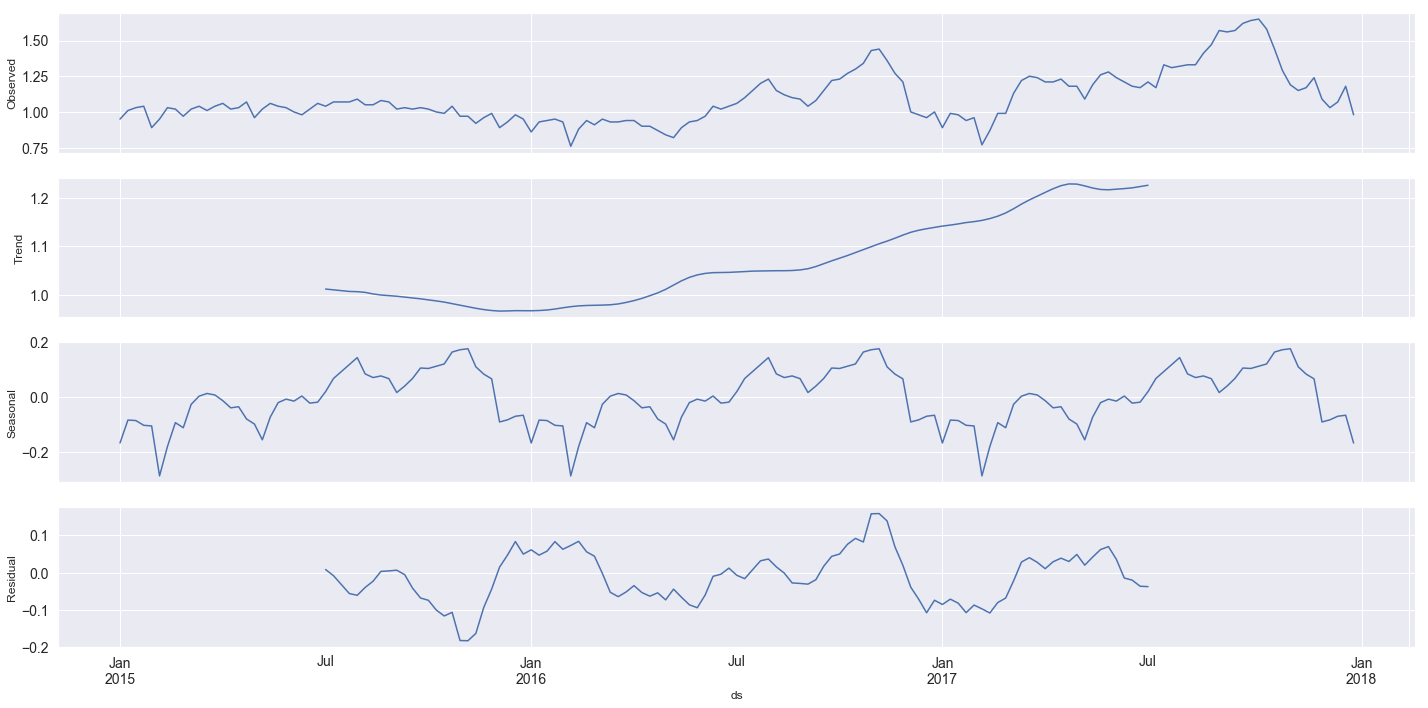

In [7]:
seasonal_decompose(train.y, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(train.y)[1])

The p-value indicates that series is not stationary.

# Box-Cox Transformation

Dickey–Fuller test: p=0.030745


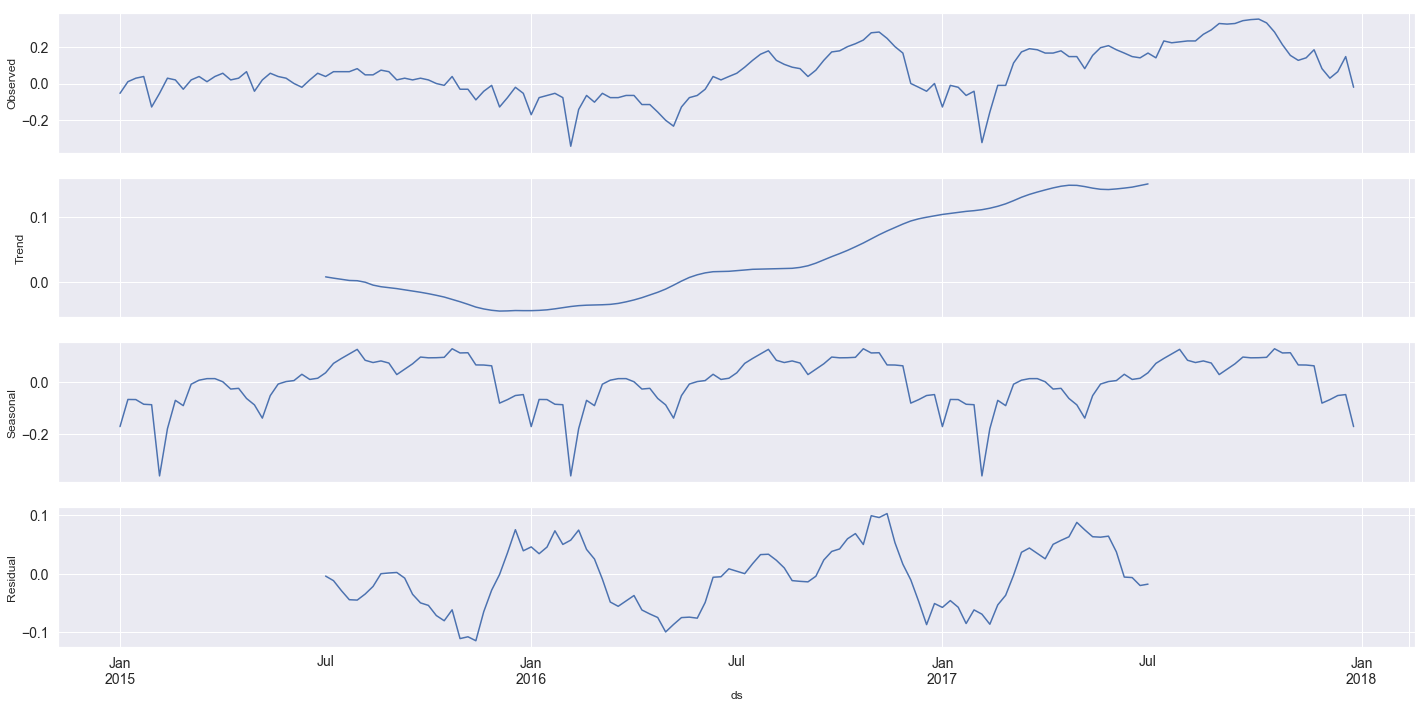

In [8]:
train['y_box'], lmbda = stats.boxcox(train.y)

seasonal_decompose(train.y_box, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(train.y_box)[1])

The p-value indicates that series is stationary.

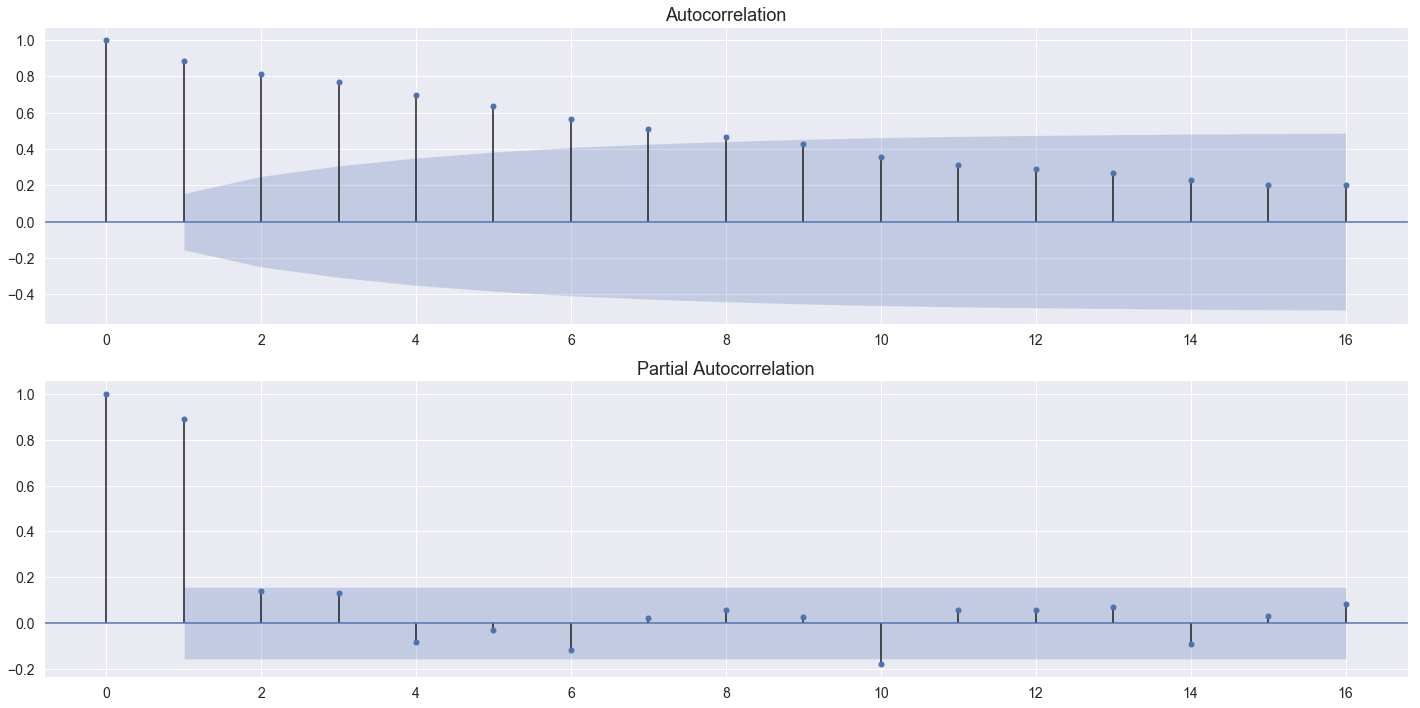

In [9]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)

# Plot the autocorrelation function
plot_acf(train.y_box[0:].values.squeeze(), lags=16, ax=ax)
ax = plt.subplot(212)
plot_pacf(train.y_box[0:].values.squeeze(), lags=16, ax=ax)
plt.tight_layout()

# Differencing
## d=1

In [10]:
train['y_box_1d'] = train['y_box'].diff(periods=1)
train.head()

,y,y_box,y_box_1d
ds,,,
2015-01-04,0.95,-0.053355,NaN
2015-01-11,1.01,0.009875,0.063230
2015-01-18,1.03,0.028902,0.019027
2015-01-25,1.04,0.038070,0.009168
2015-02-01,0.89,-0.127542,-0.165612


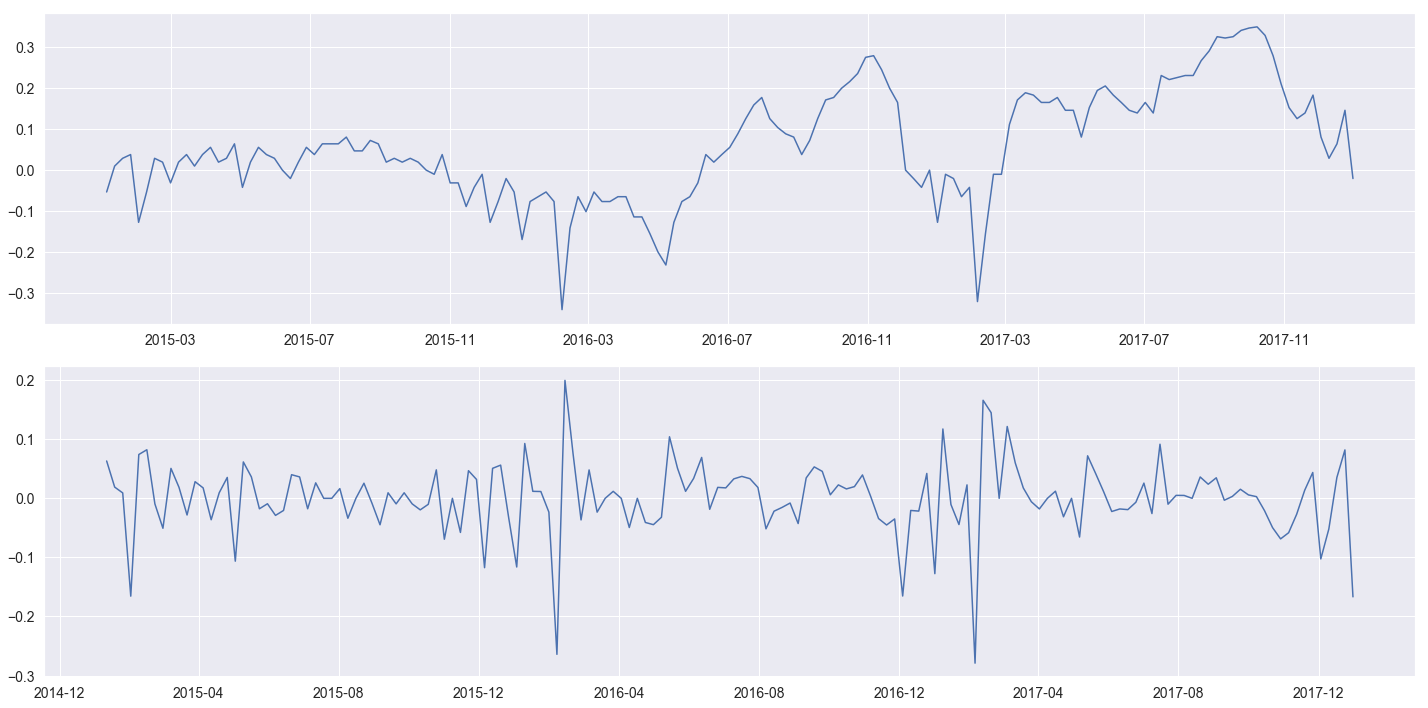

In [11]:
fig, ax_arr = plt.subplots(2,1)

ax_arr[0].plot(train.y_box)
ax_arr[1].plot(train.y_box_1d)
plt.tight_layout();

Dickey–Fuller test: p=0.000000


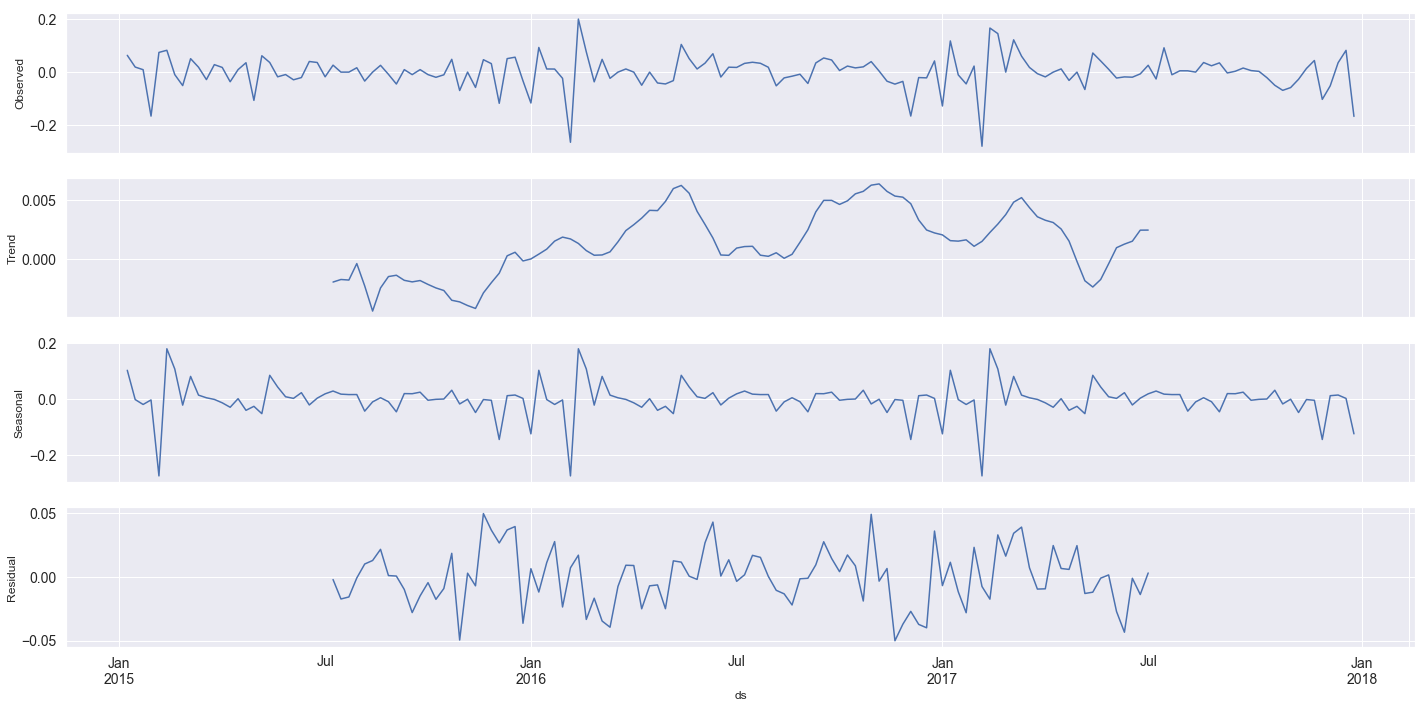

In [12]:
# STL-decomposition
seasonal_decompose(train.y_box_1d[1:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(train.y_box_1d[1:])[1])

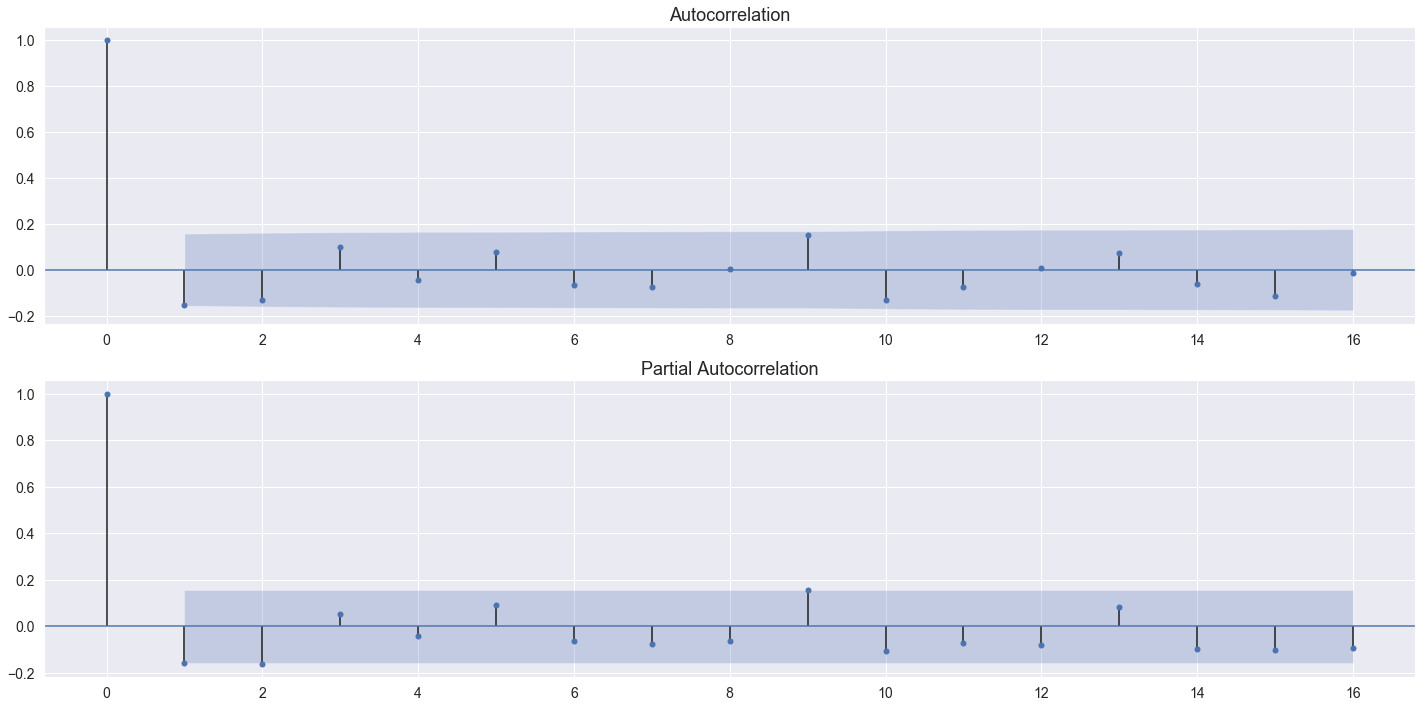

In [13]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
plot_acf(train.y_box_1d[1:].values.squeeze(), lags=16, ax=ax)
ax = plt.subplot(212)
plot_pacf(train.y_box_1d[1:].values.squeeze(), lags=16, ax=ax)
plt.tight_layout()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level $\alpha=0.01$.

There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models.

There may be a seasonal component available in the residuals at the lags of 4 weeks represented by spikes at these intervals. But probably not significant.

# ARIMA Model
AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation $ARIMA(p, d, q)$. These parameters account for seasonality, trend, and noise in datasets:

* `p` - the number of lag observations to include in the model, or lag order. ($AR$)
* `d` - the number of times that the raw observations are differenced, or the degree of differencing. ($I$)
* `q` - the size of the moving average window, also called the order of moving average.($MA$)

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates to not use that element of the model.

### Parameter Selection 
We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with `SARIMAX()` and assess its overall quality.

We will use the **AIC** (Akaike Information Criterion) value, returned with ARIMA models fitted using `statsmodels`. 

The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the **lowest AIC value**.

In [14]:
# Initial approximation of parameters
ps = range(0, 2)
d = 1
qs = range(0, 2)

parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [15]:
%%time 

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(train.y_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Wall time: 180 ms


In [16]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
1     (0, 1) -424.551904
3     (1, 1) -423.352032
2     (1, 0) -423.109474
0     (0, 0) -421.099920


Note the AICs are negative but this is not a problem.

Usually, AIC is positive; however, it can be shifted by any additive constant, and some shifts can result in negative values of AIC. It is not the absolute size of the AIC value, it is the relative values over the set of models considered, and particularly the differences between AIC values, that are important.

In [17]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                  y_box   No. Observations:                  157
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 214.276
Date:                Thu, 16 Aug 2018   AIC                           -424.552
Time:                        10:48:58   BIC                           -418.452
Sample:                    01-04-2015   HQIC                          -422.074
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2141      0.060     -3.555      0.000      -0.332      -0.096
sigma2         0.0038      0.000     15.864      0.000       0.003       0.004
Ljung-Box (Q):                       37.07   Jarque-

**Analysis of Results**

The `coef` column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The `P>|z|` column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to `0.05`, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

In [18]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


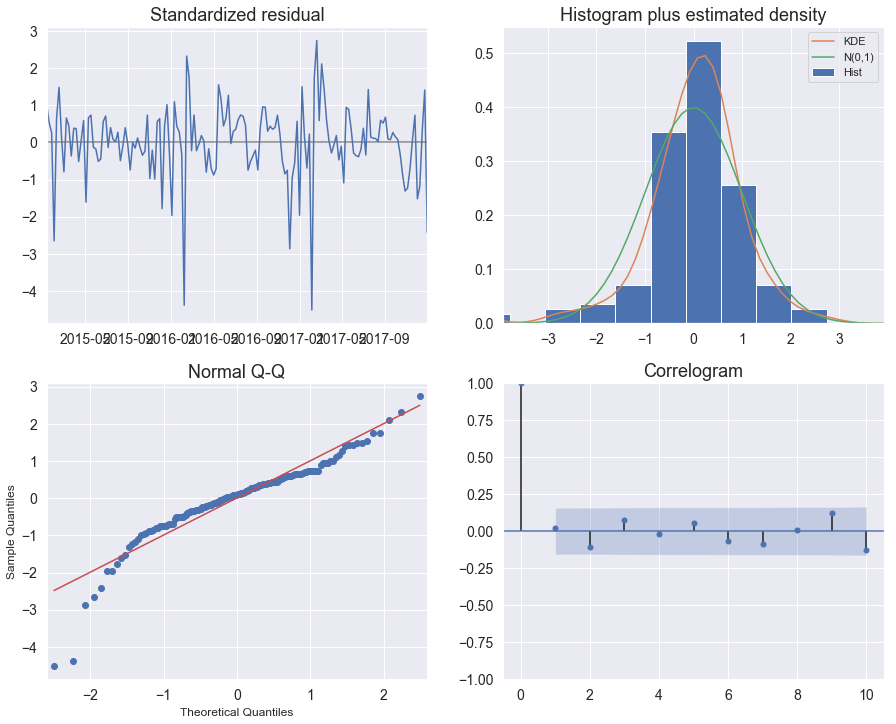

In [19]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the histogram (top right), the $KDE$ line should follow the $N(0,1)$ line (normal distribution with mean 0, standard deviation 1) closely. This is an indication whether the residuals are normally distributed or not.

In the Q-Q-plot the ordered distribution of residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with $N(0, 1)$. Again, this is an indication whether the residuals are normally distributed.

The standardized residual plot doesn't display any obvious seasonality.

This is confirmed by the autocorrelation plot, which shows that the time series residuals have low correlation with lagged versions of itself.

## Prediction 

In [20]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [21]:
test['yhat_ARIMA'] = invboxcox(best_model.forecast(12), lmbda)
test['yhat_ARIMA'] = np.round(test.yhat_ARIMA, 2)

test.tail()

,y,yhat_ARIMA
ds,,
2018-02-25,1.06,1.01
2018-03-04,1.07,1.01
2018-03-11,1.09,1.01
2018-03-18,1.05,1.01
2018-03-25,1.03,1.01


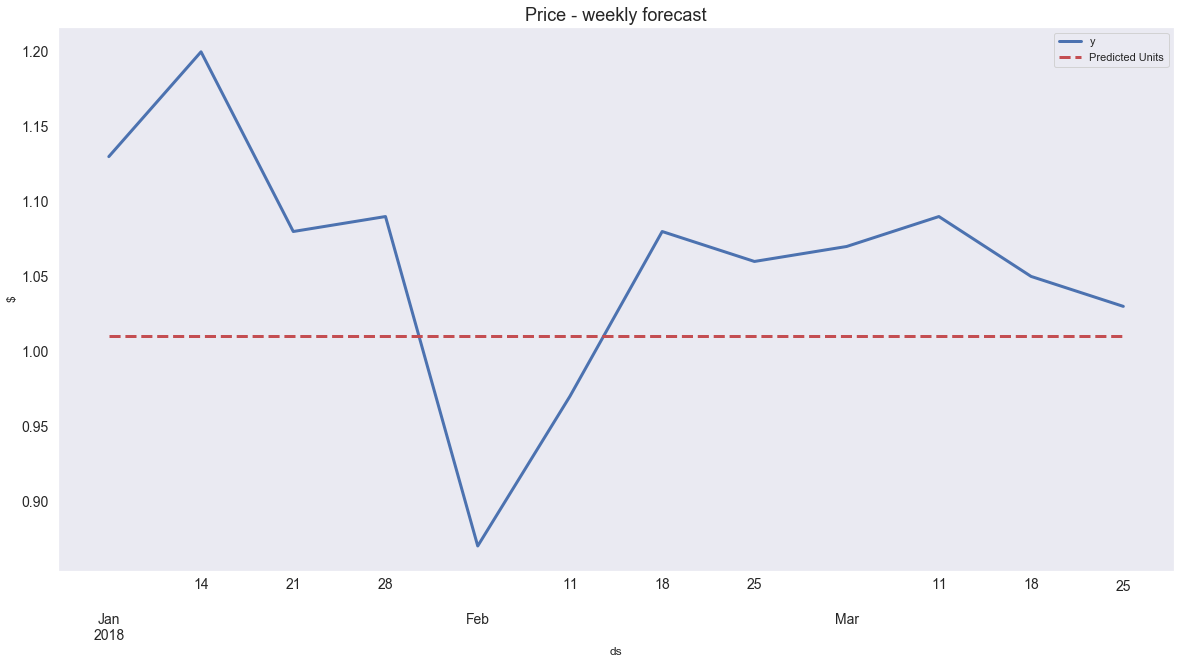

In [22]:
test.y.plot(linewidth=3)
test.yhat_ARIMA.plot(color='r', ls='--', label='Predicted Units', linewidth=3)

plt.legend()
plt.grid()
plt.title('Price - weekly forecast')
plt.ylabel('$');

In [23]:
test['e'] = test.y - test.yhat_ARIMA

rmse = np.sqrt(np.mean(test.e**2)).round(2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 0)

print('RMSE = $', rmse)
print('MAPE =', mape, '%')

RMSE = $ 0.09
MAPE = 8.0 %


# ARIMA with Constant trend

In [24]:
%%time 

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(train.y_box, order=(param[0], d, param[1]), trend='ct').fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Wall time: 346 ms


In [25]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
1     (0, 1) -420.527834
2     (1, 0) -419.270000
3     (1, 1) -419.258367
0     (0, 0) -417.282269


In [26]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                  y_box   No. Observations:                  157
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 214.264
Date:                Thu, 16 Aug 2018   AIC                           -420.528
Time:                        10:49:00   BIC                           -408.328
Sample:                    01-04-2015   HQIC                          -415.573
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.009      0.182      0.856      -0.017       0.020
drift      -2.483e-05   9.51e-05     -0.261      0.794      -0.000       0.000
ma.L1         -0.1839      0.058     -3.167      0.0

In [27]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


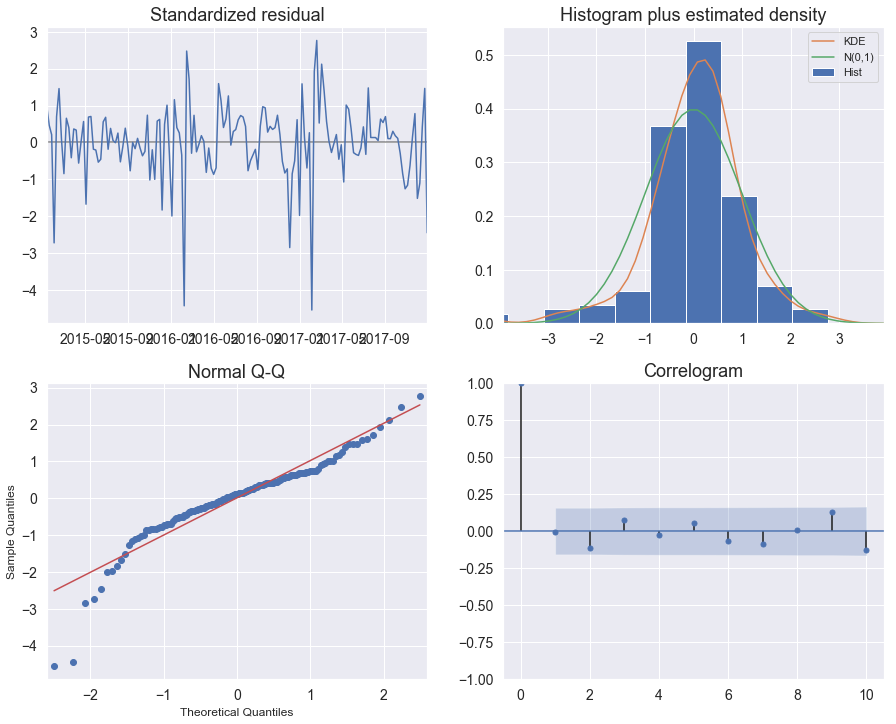

In [28]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [29]:
test['yhat_ARIMAct'] = invboxcox(best_model.forecast(12), lmbda)
test['yhat_ARIMAct'] = np.round(test.yhat_ARIMAct, 2)

test.tail()

,y,yhat_ARIMA,e,yhat_ARIMAct
ds,,,,
2018-02-25,1.06,1.01,0.05,0.99
2018-03-04,1.07,1.01,0.06,0.99
2018-03-11,1.09,1.01,0.08,0.98
2018-03-18,1.05,1.01,0.04,0.98
2018-03-25,1.03,1.01,0.02,0.98


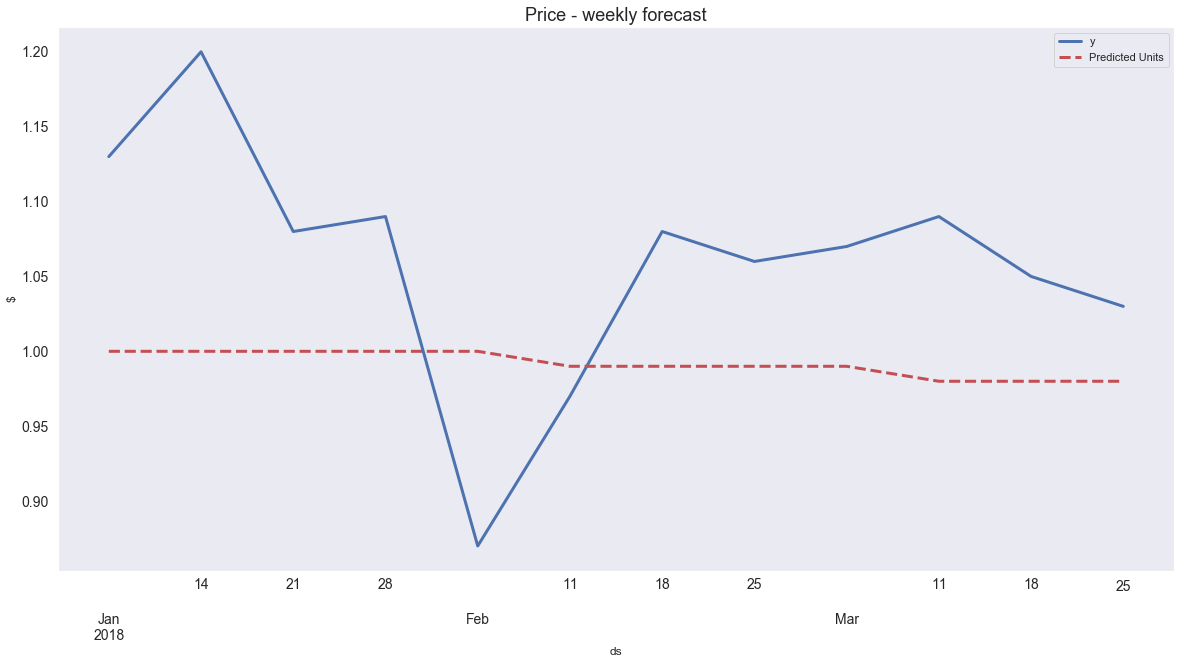

In [30]:
test.y.plot(linewidth=3)
test.yhat_ARIMAct.plot(color='r', ls='--', label='Predicted Units', linewidth=3)

plt.legend()
plt.grid()
plt.title('Price - weekly forecast')
plt.ylabel('$');

In [31]:
test['e'] = test.y - test.yhat_ARIMAct

rmse = np.sqrt(np.mean(test.e**2)).round(2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 0)

print('RMSE = $', rmse)
print('MAPE =', mape, '%')

RMSE = $ 0.1
MAPE = 9.0 %


# SARIMAX 

Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

When dealing with seasonal effects, we make use of the seasonal $ARIMA$, which is denoted as $ARIMA(p,d,q)(P,D,Q)s$. Here, $(p, d, q)$ are the non-seasonal parameters described above, while $(P, D, Q)$ follow the same definition but are applied to the seasonal component of the time series. The term $s$ is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, 52 for weekly periods etc.).

### Parameter Selection
The same process of parameter selection for seasonal ARIMA. For each combination we fit a new seasonal ARIMA model with $SARIMAX()$ and assess its overall quality.

In [32]:
%%time 

# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

i = 52 # weekly seasonality 

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(train.y_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], i)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (0, 0, 0, 1)
bad parameter combination: (0, 0, 1, 1)
bad parameter combination: (0, 0, 2, 0)
bad parameter combination: (0, 0, 2, 1)
bad parameter combination: (0, 1, 0, 1)
bad parameter combination: (0, 1, 1, 1)
bad parameter combination: (0, 1, 2, 0)
bad parameter combination: (0, 1, 2, 1)
bad parameter combination: (0, 2, 0, 1)
bad parameter combination: (0, 2, 1, 1)
bad parameter combination: (0, 2, 2, 0)
bad parameter combination: (0, 2, 2, 1)
bad parameter combination: (1, 0, 0, 1)
bad parameter combination: (1, 0, 1, 1)
bad parameter combination: (1, 0, 2, 0)
bad parameter combination: (1, 0, 2, 1)
bad parameter combination: (1, 1, 0, 1)
bad parameter combination: (1, 1, 1, 1)
bad parameter combination: (1, 1, 2, 0)
bad parameter combination: (1, 1, 2, 1)
bad parameter combination: (1, 2, 0, 1)
bad parameter combination: (1, 2, 1, 1)
bad parameter combination: (1, 2, 2, 0)
bad parameter combination: (1, 2, 2, 1)
bad parameter combination: (2, 0, 0, 1)


In [33]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

     parameters         aic
0  (0, 0, 0, 0) -286.600911
1  (0, 0, 1, 0) -285.858145
7  (1, 0, 1, 0) -285.611695
3  (0, 1, 1, 0) -285.413999
6  (1, 0, 0, 0) -285.344084
                                 Statespace Model Results                                 
Dep. Variable:                              y_box   No. Observations:                  157
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 144.300
Date:                            Thu, 16 Aug 2018   AIC                           -286.601
Time:                                    10:50:24   BIC                           -283.957
Sample:                                01-04-2015   HQIC                          -285.530
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

In [34]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[i+1:])[1])

Dickey–Fuller test:: p=0.000047


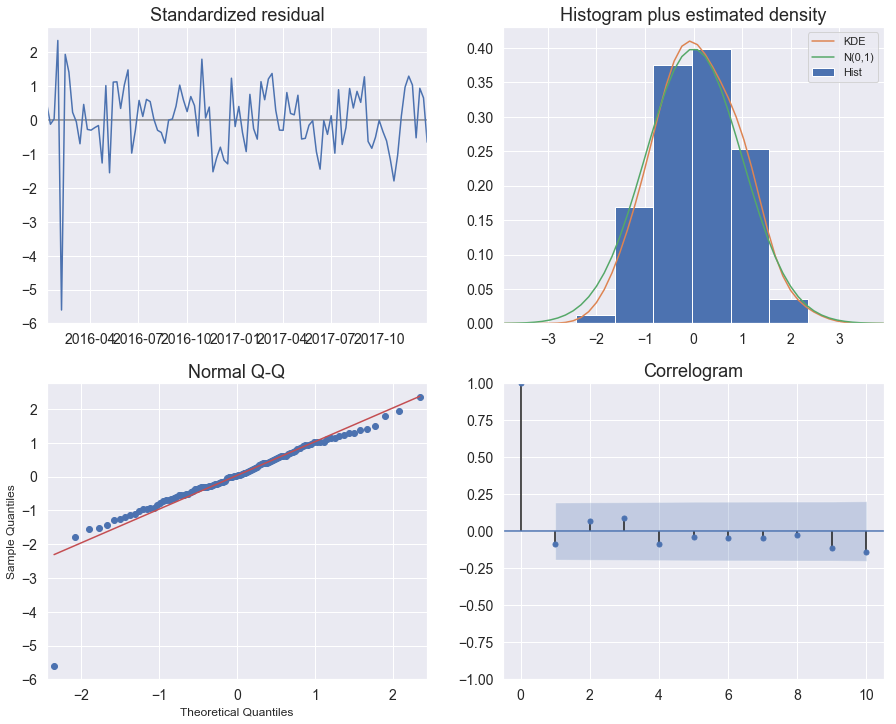

In [35]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000047


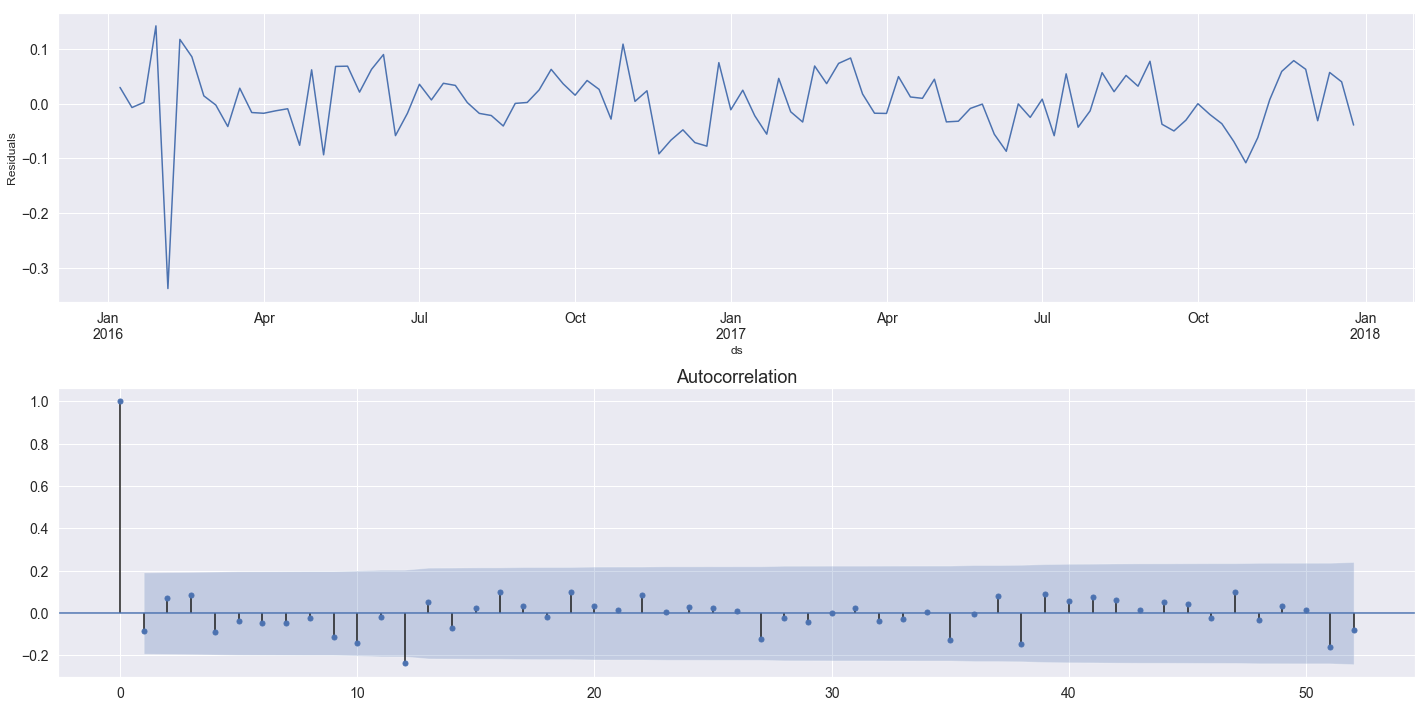

In [36]:
# STL-decomposition
plt.subplot(211)
best_model.resid[i+1:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)

plot_acf(best_model.resid[i+1:].values.squeeze(), lags=i, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[i+1:])[1])

plt.tight_layout()

In [37]:
test['yhat_SARIMA'] = invboxcox(best_model.forecast(12), lmbda)
test['yhat_SARIMA'] = np.round(test.yhat_SARIMA, 2)

test.tail()

,y,yhat_ARIMA,e,yhat_ARIMAct,yhat_SARIMA
ds,,,,,
2018-02-25,1.06,1.01,0.07,0.99,1.11
2018-03-04,1.07,1.01,0.08,0.99,1.30
2018-03-11,1.09,1.01,0.11,0.98,1.44
2018-03-18,1.05,1.01,0.07,0.98,1.48
2018-03-25,1.03,1.01,0.05,0.98,1.47


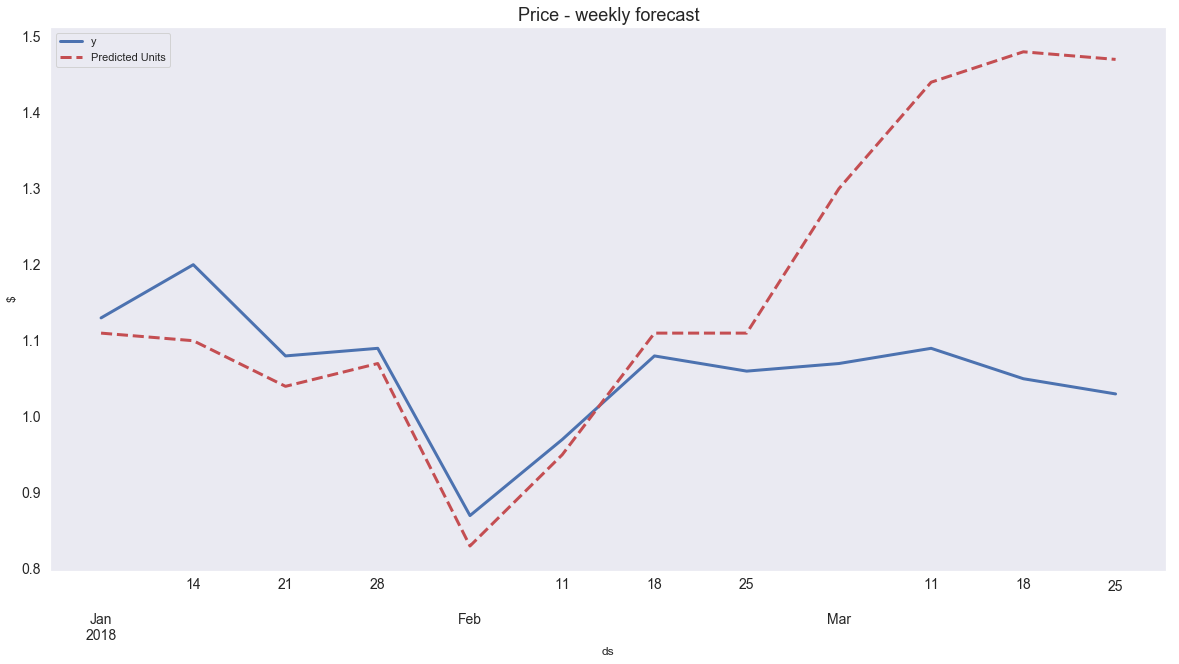

In [38]:
test.y.plot(linewidth=3)
test.yhat_SARIMA.plot(color='r', ls='--', label='Predicted Units', linewidth=3)

plt.legend()
plt.grid()
plt.title('Price - weekly forecast')
plt.ylabel('$');

In [39]:
test['e'] = test.y - test.yhat_SARIMA

rmse = np.sqrt(np.mean(test.e**2)).round(2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 0)

print('RMSE = $', rmse)
print('MAPE =', mape, '%')

RMSE = $ 0.22
MAPE = 14.0 %


# SARIMA with constant trend

In [40]:
%%time 

# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

i = 52 # weekly seasonality 

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(train.y_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], i), trend='ct').fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (0, 0, 0, 1)
bad parameter combination: (0, 0, 1, 1)
bad parameter combination: (0, 0, 2, 0)
bad parameter combination: (0, 0, 2, 1)
bad parameter combination: (0, 1, 0, 1)
bad parameter combination: (0, 1, 1, 1)
bad parameter combination: (0, 1, 2, 0)
bad parameter combination: (0, 1, 2, 1)
bad parameter combination: (0, 2, 0, 1)
bad parameter combination: (0, 2, 1, 1)
bad parameter combination: (0, 2, 2, 0)
bad parameter combination: (0, 2, 2, 1)
bad parameter combination: (1, 0, 0, 1)
bad parameter combination: (1, 0, 1, 1)
bad parameter combination: (1, 0, 2, 0)
bad parameter combination: (1, 0, 2, 1)
bad parameter combination: (1, 1, 0, 1)
bad parameter combination: (1, 1, 1, 1)
bad parameter combination: (1, 1, 2, 0)
bad parameter combination: (1, 1, 2, 1)
bad parameter combination: (1, 2, 0, 1)
bad parameter combination: (1, 2, 1, 1)
bad parameter combination: (1, 2, 2, 0)
bad parameter combination: (1, 2, 2, 1)
bad parameter combination: (2, 0, 0, 1)


In [41]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

     parameters         aic
0  (0, 0, 0, 0) -282.862029
1  (0, 0, 1, 0) -282.086348
6  (1, 0, 0, 0) -281.650595
2  (0, 1, 0, 0) -281.516973
7  (1, 0, 1, 0) -281.300757
                                 Statespace Model Results                                 
Dep. Variable:                              y_box   No. Observations:                  157
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 144.431
Date:                            Thu, 16 Aug 2018   AIC                           -282.862
Time:                                    10:54:52   BIC                           -274.929
Sample:                                01-04-2015   HQIC                          -279.648
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

In [42]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[i+1:])[1])

Dickey–Fuller test:: p=0.000027


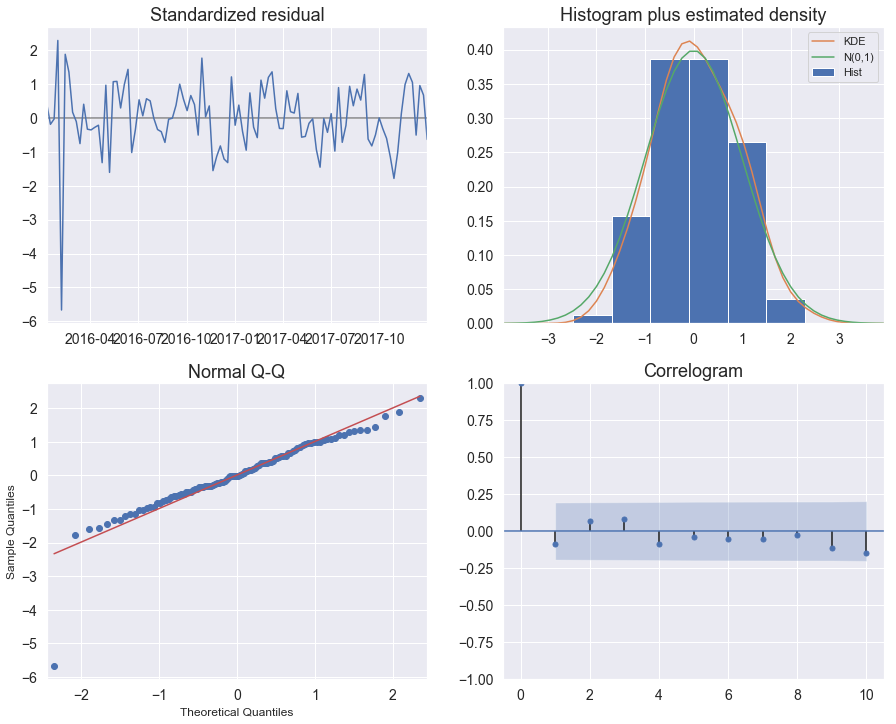

In [43]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000027


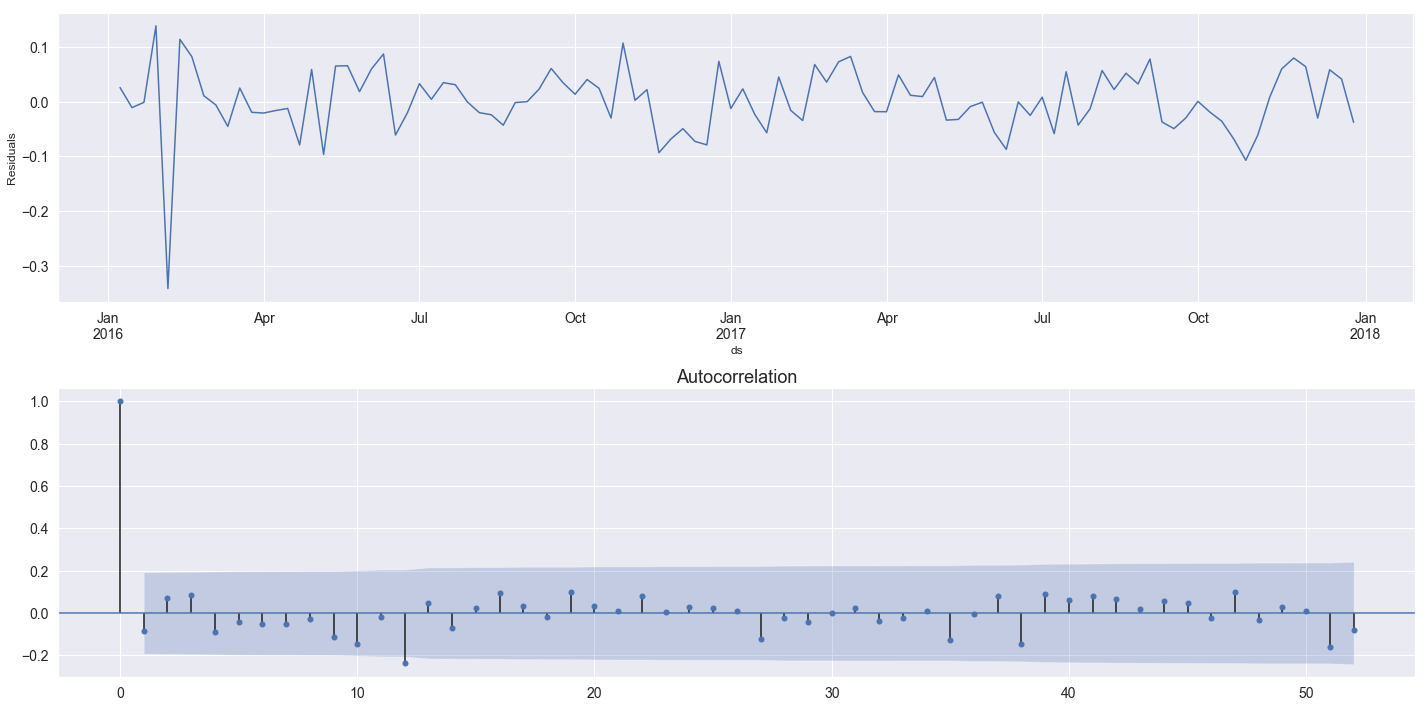

In [44]:
# STL-decomposition
plt.subplot(211)
best_model.resid[i+1:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)

plot_acf(best_model.resid[i+1:].values.squeeze(), lags=i, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[i+1:])[1])

plt.tight_layout()

In [45]:
test['yhat_SARIMAct'] = invboxcox(best_model.forecast(12), lmbda)
test['yhat_SARIMAct'] = np.round(test.yhat_SARIMAct, 2)

test.tail()

,y,yhat_ARIMA,e,yhat_ARIMAct,yhat_SARIMA,yhat_SARIMAct
ds,,,,,,
2018-02-25,1.06,1.01,-0.05,0.99,1.11,1.10
2018-03-04,1.07,1.01,-0.23,0.99,1.30,1.28
2018-03-11,1.09,1.01,-0.35,0.98,1.44,1.40
2018-03-18,1.05,1.01,-0.43,0.98,1.48,1.44
2018-03-25,1.03,1.01,-0.44,0.98,1.47,1.42


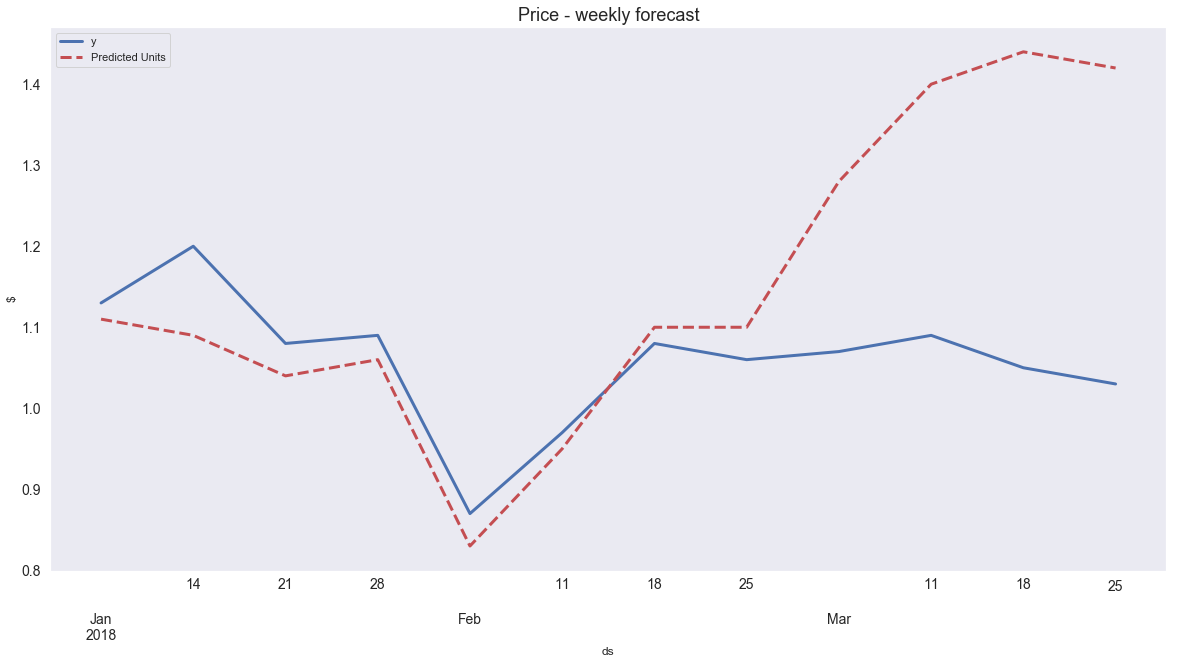

In [46]:
test.y.plot(linewidth=3)
test.yhat_SARIMAct.plot(color='r', ls='--', label='Predicted Units', linewidth=3)

plt.legend()
plt.grid()
plt.title('Price - weekly forecast')
plt.ylabel('$');

In [47]:
test['e'] = test.y - test.yhat_SARIMAct

rmse = np.sqrt(np.mean(test.e**2)).round(2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 0)

print('RMSE = $', rmse)
print('MAPE =', mape, '%')

del test['e']

RMSE = $ 0.2
MAPE = 13.0 %


In [48]:
test

,y,yhat_ARIMA,yhat_ARIMAct,yhat_SARIMA,yhat_SARIMAct
ds,,,,,
2018-01-07,1.13,1.01,1.00,1.11,1.11
2018-01-14,1.20,1.01,1.00,1.10,1.09
2018-01-21,1.08,1.01,1.00,1.04,1.04
2018-01-28,1.09,1.01,1.00,1.07,1.06
2018-02-04,0.87,1.01,1.00,0.83,0.83
2018-02-11,0.97,1.01,0.99,0.95,0.95
2018-02-18,1.08,1.01,0.99,1.11,1.10
2018-02-25,1.06,1.01,0.99,1.11,1.10
2018-03-04,1.07,1.01,0.99,1.30,1.28


# Results so far

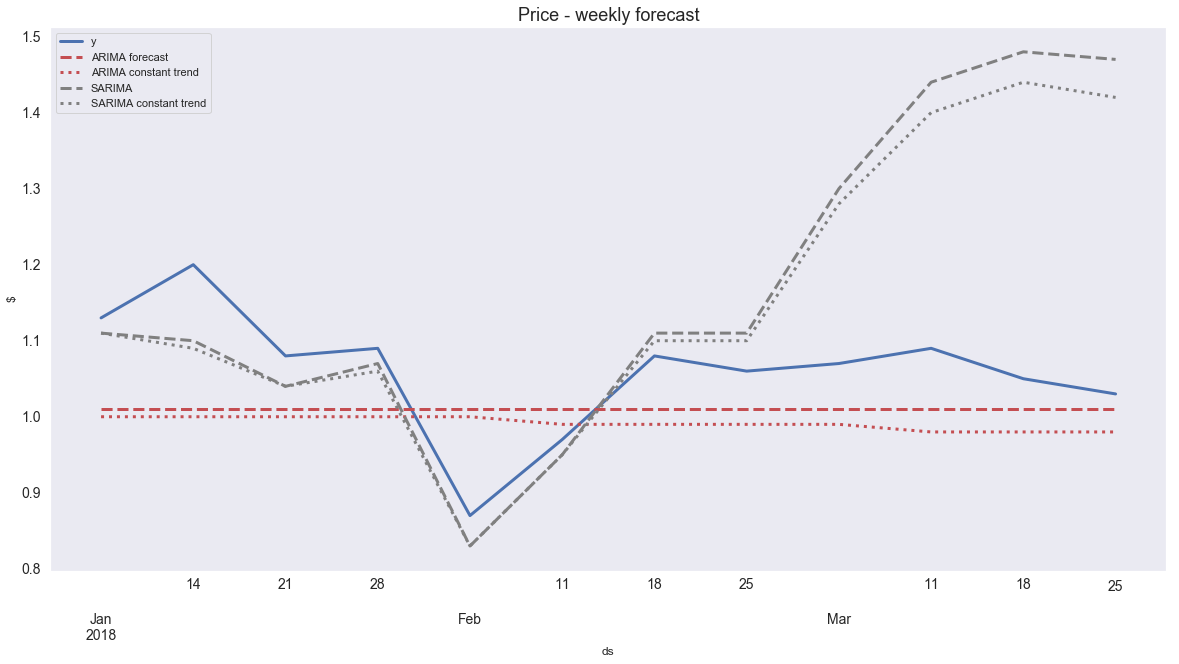

In [53]:
test.y.plot(linewidth=3)

test.yhat_ARIMA.plot(color='r', ls='--', label='ARIMA forecast', linewidth=3)
test.yhat_ARIMAct.plot(color='r', ls=':', label='ARIMA constant trend', linewidth=3)
test.yhat_SARIMA.plot(color='grey', ls='--', label='SARIMA', linewidth=3)
test.yhat_SARIMAct.plot(color='grey', ls=':', label='SARIMA constant trend', linewidth=3)

plt.legend()
plt.grid()
plt.title('Price - weekly forecast')
plt.ylabel('$');

# Do avocados and bread go together? Let's find out!

## Average price of bread 
[Source](https://data.bls.gov/cgi-bin/surveymost?ap) : U.S. Bureau of Labor Statistics 

In [84]:
bread = pd.read_csv('data/cpi_bread.csv')
bread['Month'] = pd.to_datetime(bread.Month, format='%d/%m/%Y')

bread.columns = ['ds', 'y']

bread = bread.sort_values("ds")

bread.columns = ['ds', 'y']
bread.set_index('ds', inplace=True)

bread.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2015-01-01 to 2018-07-01
Data columns (total 1 columns):
y    43 non-null float64
dtypes: float64(1)
memory usage: 688.0 bytes


In [85]:
bread.tail()

,y
ds,
2018-03-01,1.309
2018-04-01,1.281
2018-05-01,1.293
2018-06-01,1.279
2018-07-01,1.293


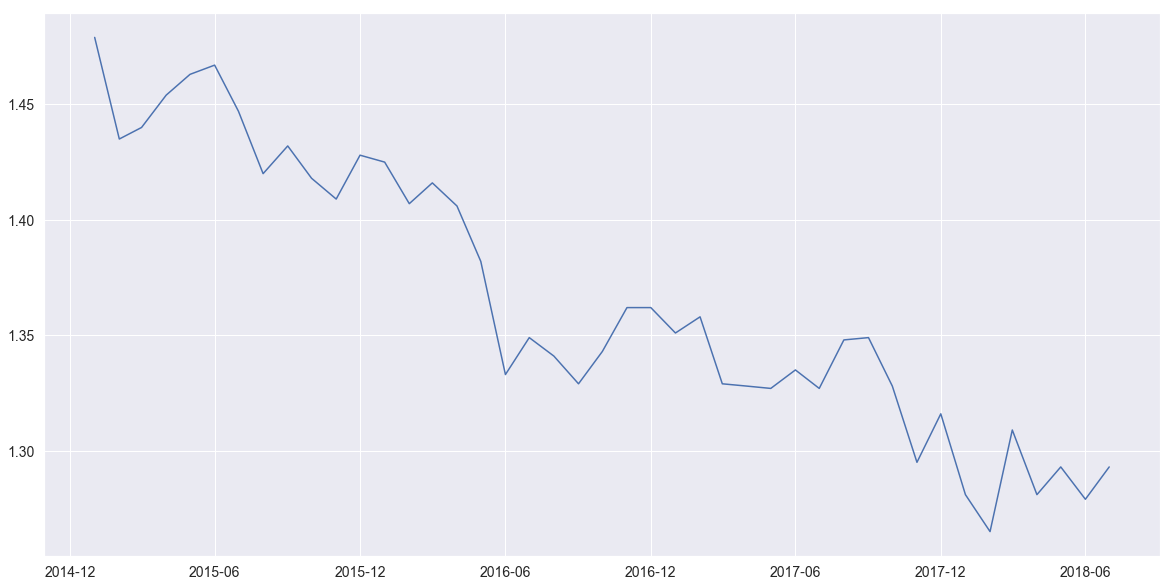

In [86]:
plt.plot(bread);

This is a time series with visible downward trend. Lets make it stationary

Dickey–Fuller test: p=0.909621


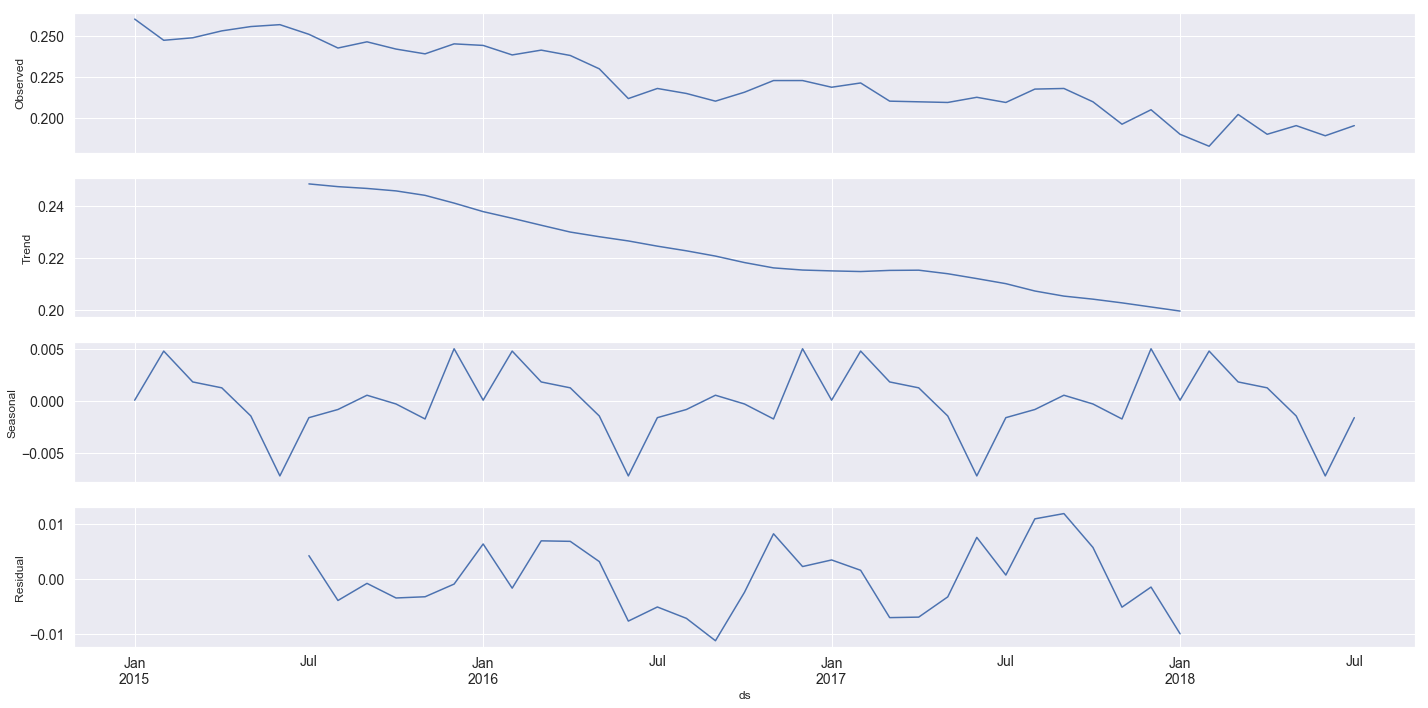

In [87]:
# Box-Cox Transformations
bread['y_box'], lmbda = stats.boxcox(bread.y)
seasonal_decompose(bread.y_box, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(bread.y_box)[1])

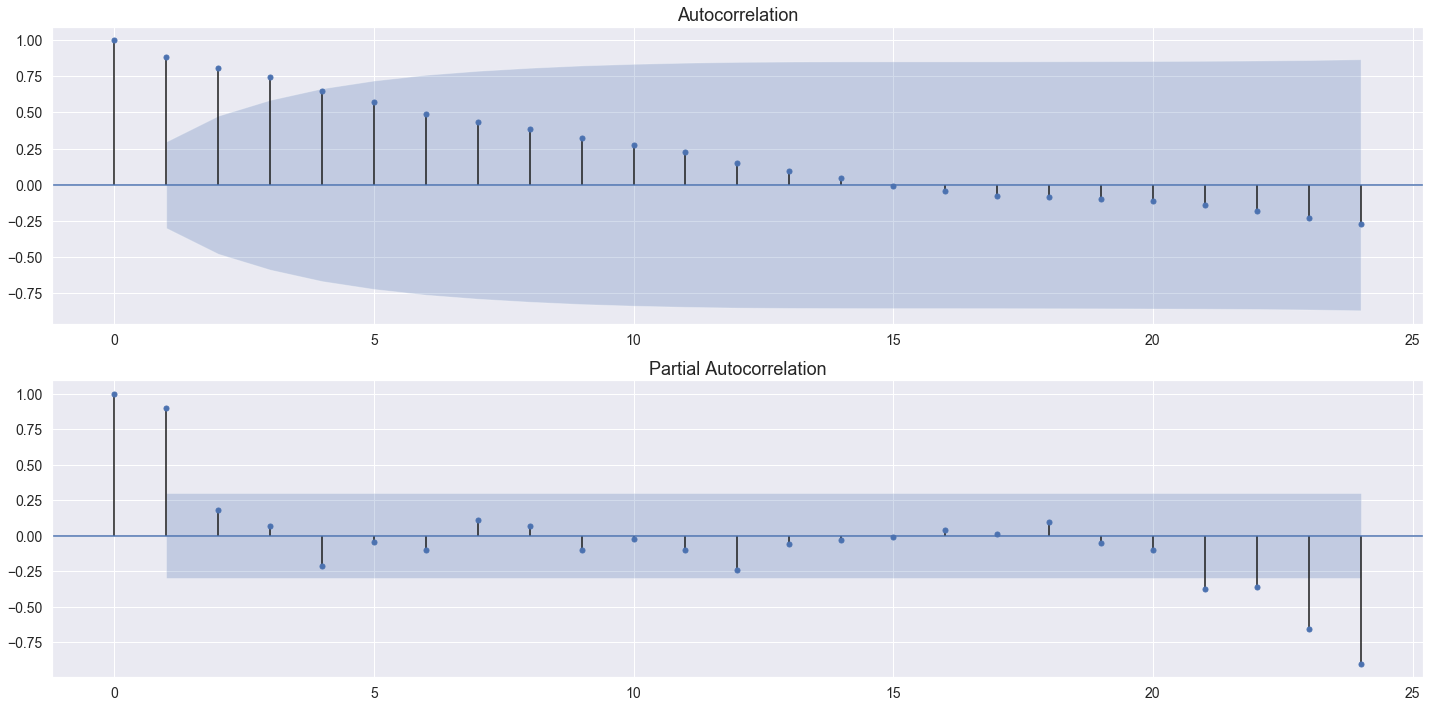

In [88]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
plot_acf(bread.y_box[0:].values.squeeze(), lags=24, ax=ax)
ax = plt.subplot(212)
plot_pacf(bread.y_box[0:].values.squeeze(), lags=24, ax=ax)
plt.tight_layout()

In [89]:
bread['y_box_1d'] = bread['y_box'].diff(periods=1)
bread.tail()

,y,y_box,y_box_1d
ds,,,
2018-03-01,1.309,0.201947,0.019391
2018-04-01,1.281,0.189858,-0.012089
2018-05-01,1.293,0.195143,0.005285
2018-06-01,1.279,0.188961,-0.006182
2018-07-01,1.293,0.195143,0.006182


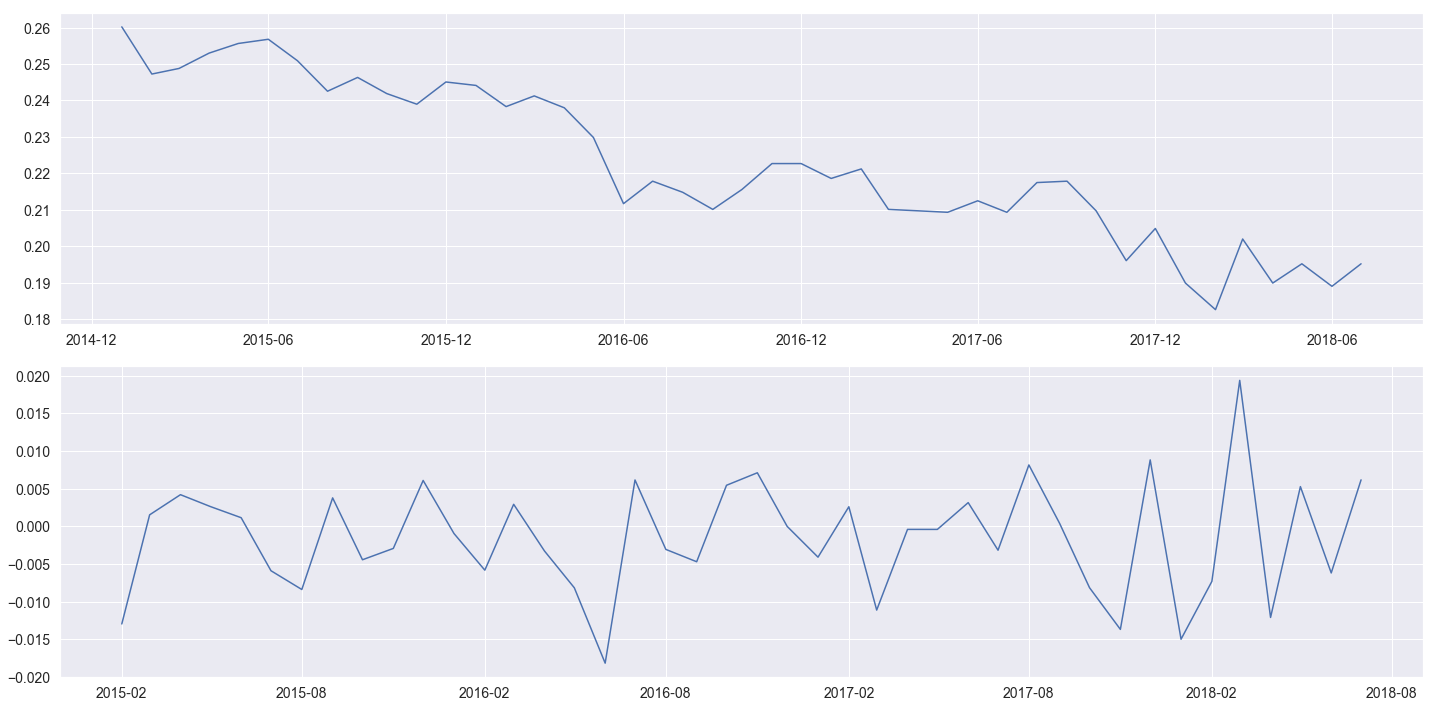

In [90]:
fig, ax_arr = plt.subplots(2,1)

ax_arr[0].plot(bread.y_box)
ax_arr[1].plot(bread.y_box_1d)
plt.tight_layout();

Dickey–Fuller test: p=0.000005


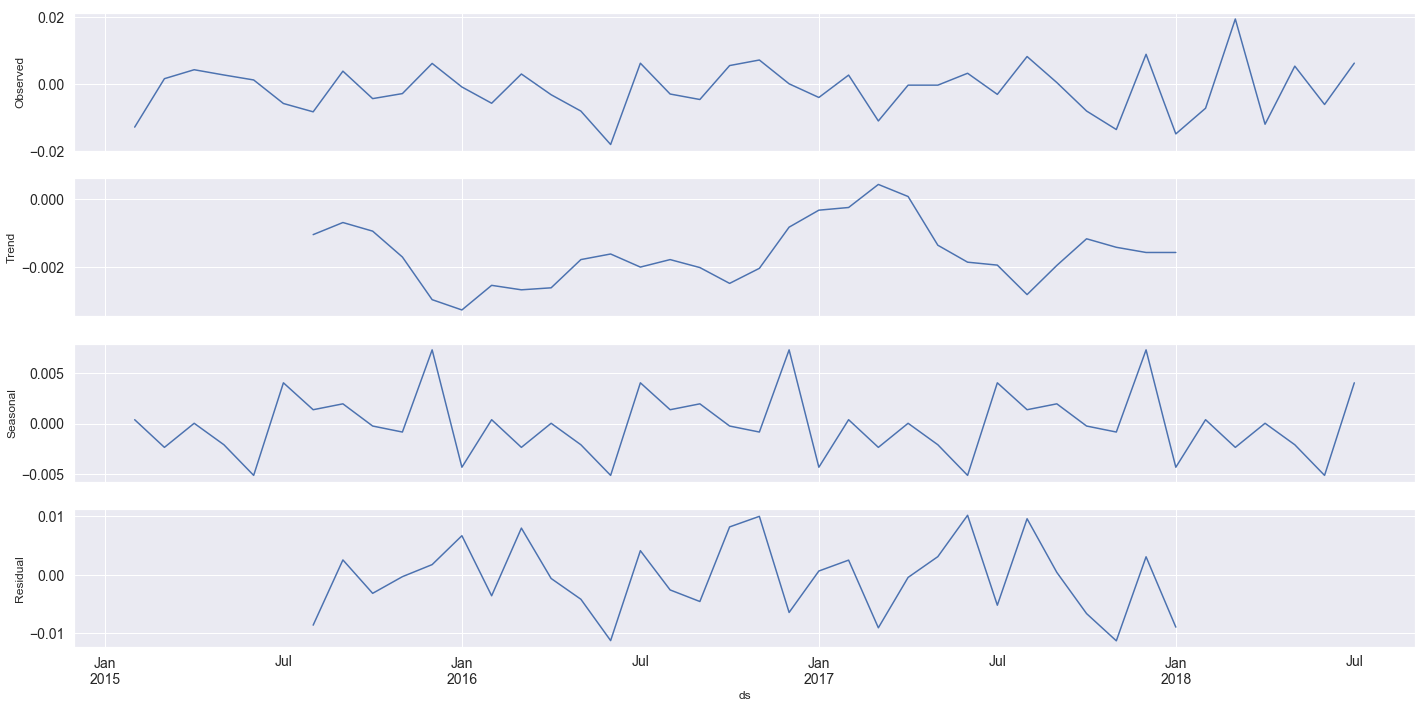

In [91]:
# STL-decomposition
seasonal_decompose(bread.y_box_1d[1:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(bread.y_box_1d[1:])[1])

Now this is a stationary time series